# Using Dask to parallel process the global mean sea level anomaly using PO.DAAC data in the cloud

#### Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>

#### June 13, 2022

This notebook demonstrates the Dask parallel calculation of a POCLOUD product within the AWS cloud. This code can only be run in the AWS US-West-2. 

The global mean sea level is an important climate indicator. It can be calculated from the global-gridded altimetry product. In this example, we will use the gridded MEaSUREs sea surface height (SSH) Level-4 product hosted in POCLOUD. The details can be found on the product's [landing page](https://podaac.jpl.nasa.gov/dataset/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812).

The gridded SSH product has 1992 files. Each file represents a 5-day mean sea surface height on a 1/6-degree grid. In this demonstration, we first show that calculating the global mean sea level from the 1922 files takes 17 minutes if we use a signal thread, but 42 seconds if we use Dask with 32 workers. 



In [1]:
import xarray as xr
import numpy as np
import pylab as plt
import pandas as pd
#Short_name is used to identify a specific dataset in NASA Earthdata. 
short_name='SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812'

## Get the handle to the AWS S3 file system

PO.DAAC cloud (POCLOUD) is a part of Earthdata Cloud. The data are hosted in a S3 bucket on AWS US-West-2. "US-West-2" is a term that refers to the AWS center in Oregon. In this case, the so-called 'Direct-S3 access' only works on the machines hosted in the US-West-2. 

**s3fs** is a pythonic file interface to S3 built on top of [botocore](https://github.com/boto/botocore). s3fs allows typical file-system style operations like cp, mv, ls, du, glob, and put/get of local files to/from S3. Details can be find on its website https://s3fs.readthedocs.io/en/latest/.  

It is important that you set up the .netrc file correctly in order to enable the following *init_S3FileSystem* module. The .netrc file should be placed in your home folder. A typical .netrc file has the following content:
```bash
machine urs.earthdata.nasa.gov
    login your_earthdata_username
    password your_earthdata_account_password
 ```
 
If you do not have or do not remember your Earthdata Login information, go [here](https://urs.earthdata.nasa.gov/users/new) to register or [here](https://urs.earthdata.nasa.gov/reset_passwords/new) to reset password. 

In [2]:
def init_S3FileSystem():
    import requests,s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3

## Use s3fs.glob to get all file names

Once the s3fs file system is established, we can use 'glob' to get all file names from a collection. In this case, the collection S3 path is 
```bash
s3://podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/
```

Using the following will get a list netcdf filenames: 
```
fns=s3sys.glob("s3://podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/*.nc")
```

In [3]:
s3sys=init_S3FileSystem()

s3path="s3://podaac-ops-cumulus-protected/%s/"%short_name
fns=s3sys.glob(s3path+"*.nc")
print(fns[0])
#Set the time stamps associated with the files
time=pd.date_range(start='1992-10-02',periods=len(fns),freq='5D')

podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_1992100212.nc


In [4]:
print('There are %i files.'%len(fns))

There are 1922 files.


In [5]:
d=xr.open_dataset(s3sys.open(fns[0]))
d

<xarray.Dataset>
Dimensions:      (Longitude: 2160, nv: 2, Latitude: 960, Time: 1)
Coordinates:
  * Longitude    (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * Latitude     (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Time         (Time) datetime64[ns] 1992-10-02T12:00:00
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Longitude, nv) float32 ...
    Lat_bounds   (Latitude, nv) float32 ...
    Time_bounds  (Time, nv) datetime64[ns] ...
    SLA          (Time, Longitude, Latitude) float32 ...
    SLA_ERR      (Time, Longitude, Latitude) float32 ...
Attributes: (12/13)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    time_coverage_start:    1992-10-02
    time_coverage_end:      1992-10-02
    date_created:           2019-02-11T20:19:57.736094
    version_number:         1812
    summary:                Sea level anomaly grids from altimeter data using...
    title:                  Sea Level Anormaly Estimate based on Altimeter Data

## Calcualte the grid area 

The grid area associated with each grid is uniform in longitude. We only need to calculate the grid area for one longitude. 

In [6]:
def area(lats):
    # Modules:
    from pyproj import Geod
    # Define WGS84 as CRS:
    geod = Geod(ellps='WGS84')
    dx=1/12.0
    c_area=lambda lat: geod.polygon_area_perimeter(np.r_[-dx,dx,dx,-dx], lat+np.r_[-dx,-dx,dx,dx])[0]
    out=[]
    for lat in lats:
        out.append(c_area(lat))
    return np.array(out)

ssh_area=area(d.Latitude.data).reshape(1,-1)


## Calculate the global mean SSHA

Use the area to calculate the area associated with each grid. The global mean SSH is calculated as follows. 

$SSH_{mean} = \sum \eta(\phi,\lambda)*A(\phi)$, where $\phi$ is latitude, $\lambda$ is longitude, $A$ is the area of the grid at latitude $\phi$, and $\eta(\phi,\lambda)*A(\phi)$ is the SLA at $(\phi,\lambda)$. 

In [7]:
def global_mean(fn_s3,s3sys,ssh_area):
    with xr.open_dataset(s3sys.open(fn_s3))['SLA'] as d:
        dout=((d*ssh_area).sum()/(d/d*ssh_area).sum()).values
    return dout

In [8]:
print(global_mean(fns[0],s3sys,ssh_area) )

-0.006323621041507964


## Demonstrate use a single thread

Benchmark: using a sigle thread takes about 17 min to calculate all 1922 files. Here the program is sped up by skipping every 360 days. 

CPU times: user 4.6 s, sys: 1.08 s, total: 5.68 s
Wall time: 10 s


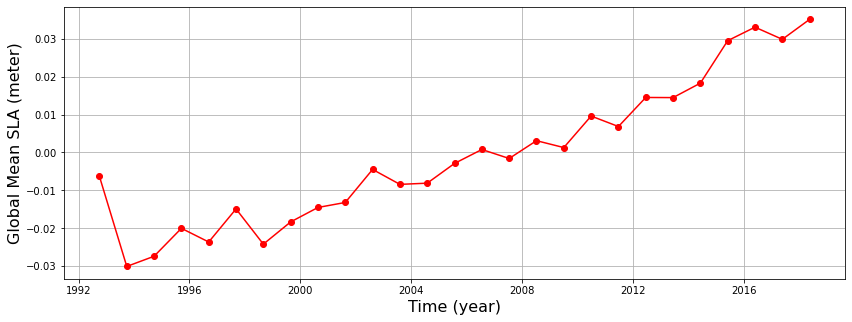

In [9]:
%%time

result=[]

for fn in fns[::72]:
    result.append(global_mean(fn,s3sys,ssh_area) )
plt.figure(figsize=(14,5))
plt.plot(time[::72],result,'r-o')
plt.xlabel('Time (year)',fontsize=16)
plt.ylabel('Global Mean SLA (meter)',fontsize=16)
plt.grid(True)

## Now let us try Dask

Benchmark: It took 44 seconds to go through the 1922 files using 8 workers on an instance c3.xlarge. 

In [10]:
from dask.distributed import Client
from dask import delayed,compute
client = Client('tcp://127.0.0.1:44989')

In [11]:
client

<Client: 'tcp://127.0.0.1:44989' processes=8 threads=32, memory=58.74 GiB>

In [12]:
%%time

result=[]

for fn in fns:
    result.append(delayed(global_mean)(fn,s3sys,ssh_area) )

output=np.array(compute(result)).squeeze()

CPU times: user 2.2 s, sys: 322 ms, total: 2.52 s
Wall time: 46.3 s


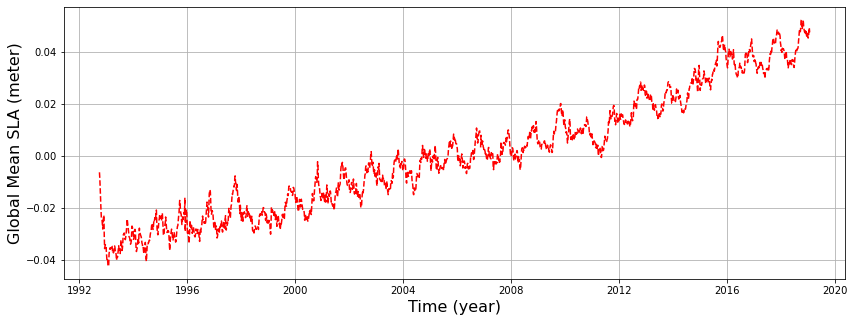

In [13]:
plt.figure(figsize=(14,5))
plt.plot(time,output,'r--')
plt.xlabel('Time (year)',fontsize=16)
plt.ylabel('Global Mean SLA (meter)',fontsize=16)
plt.grid(True)